# Importing Libraries

In [ ]:
import io
import re
import time
import zipfile
import unicodedata
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Loading Dataset

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip -O /tmp/fra-eng.zip

--2020-07-09 17:58:13--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6041598 (5.8M) [application/zip]
Saving to: ‘/tmp/fra-eng.zip’

/tmp/fra-eng.zip    100%[===================>]   5.76M  17.0MB/s    in 0.3s    

2020-07-09 17:58:13 (17.0 MB/s) - ‘/tmp/fra-eng.zip’ saved [6041598/6041598]



In [ ]:
local_training_zip = '/tmp/fra-eng.zip'
if zipfile.is_zipfile(filename=local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r', compression=0, allowZip64=True)
    zip_ref.extractall(path='/tmp/')
    zip_ref.close()

In [ ]:
PATH_TO_FILE = '/tmp/fra.txt'

# Preparing Dataset

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [ ]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # removing spaces at start & end of sentence
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    return w

In [ ]:
def create_dataset(path, num_examples=None, sent_len=None):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    if sent_len is None:
        word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1]]  for l in lines[:num_examples]]
    else:
        word_pairs = []
        for line in lines[:num_examples]:
            sentences = [preprocess_sentence(w) for w in line.split('\t')[:-1]]
            if((len(sentences[0].split()) < sent_len) & (len(sentences[1].split()) < sent_len)):
                word_pairs.append(sentences)

    
    return zip(*word_pairs)

In [ ]:
en, fr = create_dataset(path=PATH_TO_FILE, num_examples=None, sent_len=30)

In [ ]:
def unique_words(data):
    tmp, mx = [], -1
    for i in data:
        lst = i.split()
        tmp.extend(lst)
        mx = max(len(lst), mx)
    return list(set(tmp)), mx

In [ ]:
u_en, mx_en = unique_words(data=en)
print('No. of unique words in en:', len(u_en))
print('Max-length of sentences:', mx_en, end='\n\n')

u_fr, mx_fr = unique_words(data=en)
print('No. of unique words in fr:', len(u_fr))
print('Max-length of sentences:', mx_fr)

No. of unique words in en: 13975
Max-length of sentences: 29

No. of unique words in fr: 13975
Max-length of sentences: 29


# Tokenization

In [ ]:
EN_VOCAB_SIZE = 10000
EN_MX_LEN = 30

FR_VOCAB_SIZE = 10000
FR_MX_LEN = 30

In [ ]:
def tokenize(data, num_words, subword=False):
    if subword:
        tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
            corpus_generator=data,
            target_vocab_size=num_words,
            max_subword_length=20,
            max_corpus_chars=None,
            reserved_tokens=['<start>', '<end>']
        )

    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=num_words,
            filters='',
            lower=True,
            split=' ',
            char_level=False,
            oov_token=None
        )
        tokenizer.fit_on_texts(texts=data)
    
    return tokenizer

In [ ]:
en_tokenizer = tokenize(data=en, num_words=EN_VOCAB_SIZE, subword=False)
fr_tokenizer = tokenize(data=fr, num_words=FR_VOCAB_SIZE, subword=False)

In [ ]:
print('English => index-to-word:')
for i in range(1, 10):
    print(i, '--> ' + en_tokenizer.index_word[i])
print('\nFrench => index-to-word:')
for i in range(1, 10):
    print(i, '--> ' + fr_tokenizer.index_word[i])

print('\nEnglish => word-to-index:')
for i in range(1, 10):
    print(list(en_tokenizer.word_index)[i] + ' -->', i)
print('\nFrench => index-to-word:')
for i in range(1, 10):
    print(list(fr_tokenizer.word_index)[i] + ' -->', i)

print('\nEnglish => word-counts:')
for i in range(1, 10):
    print(list(en_tokenizer.word_counts.keys())[i] + ' -->', list(en_tokenizer.word_counts.values())[i])
print('\nFrench => word-counts:')
for i in range(1, 10):
    print(list(fr_tokenizer.word_counts.keys())[i] + ' -->', list(fr_tokenizer.word_counts.values())[i])

English => index-to-word:
1 --> <start>
2 --> <end>
3 --> .
4 --> i
5 --> you
6 --> to
7 --> the
8 --> ?
9 --> a

French => index-to-word:
1 --> <start>
2 --> <end>
3 --> .
4 --> je
5 --> a
6 --> de
7 --> ?
8 --> pas
9 --> est

English => word-to-index:
<end> --> 1
. --> 2
i --> 3
you --> 4
to --> 5
the --> 6
? --> 7
a --> 8
t --> 9

French => index-to-word:
<end> --> 1
. --> 2
je --> 3
a --> 4
de --> 5
? --> 6
pas --> 7
est --> 8
vous --> 9

English => word-counts:
go --> 4294
. --> 148187
<end> --> 177098
hi --> 19
run --> 298
! --> 1298
who --> 2459
? --> 29348
wow --> 12

French => word-counts:
va --> 1465
! --> 5591
<end> --> 177098
salut --> 19
. --> 143731
cours --> 225
courez --> 11
qui --> 4767
? --> 29368


In [ ]:
# print('EN_TOKENIZER_VOCAB_SIZE:', en_tokenizer.vocab_size)
# print('FR_TOKENIZER_VOCAB_SIZE:', fr_tokenizer.vocab_size)

# print('\nEN_TOKENIZER_SUBWORDS:')
# print(en_tokenizer.subwords)
# print('FR_TOKENIZER_SUBWORDS:')
# print(fr_tokenizer.subwords)

In [ ]:
# en_sequences = [en_tokenizer.encode(s=sentence) for sentence in en]
# fr_sequences_in = [fr_tokenizer.encode(s=sentence) for sentence in fr]
# fr_sequences_out = [seq[1:] for seq in fr_sequences_in]

In [ ]:
en_sequences = en_tokenizer.texts_to_sequences(texts=en)
fr_sequences_in = fr_tokenizer.texts_to_sequences(texts=fr)
fr_sequences_out = [seq[1:] for seq in fr_sequences_in]

In [ ]:
def pad(data, pad_maxlen, pad_type, trunc_type):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences=data, maxlen=pad_maxlen, padding=pad_type, truncating=trunc_type, value=0.0)

In [ ]:
en_pad_sequences = pad(data=en_sequences, pad_maxlen=EN_MX_LEN, pad_type='pre', trunc_type='pre')
fr_pad_sequences_in = pad(data=fr_sequences_in, pad_maxlen=FR_MX_LEN, pad_type='post', trunc_type='post')
fr_pad_sequences_out = pad(data=fr_sequences_out, pad_maxlen=FR_MX_LEN, pad_type='post', trunc_type='post')

In [ ]:
print(en_pad_sequences.shape)
print(fr_pad_sequences_in.shape)
print(fr_pad_sequences_out.shape)

(177098, 30)
(177098, 30)
(177098, 30)


In [ ]:
NUM_EPOCHS = 10
BUFFER_SIZE = 10000
BATCH_SIZE = 73
assert en_pad_sequences.shape[0]%BATCH_SIZE == 0
TRAIN_BATCH_SIZE = en_pad_sequences.shape[0]//BATCH_SIZE

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tensors=(en_pad_sequences, fr_pad_sequences_in, fr_pad_sequences_out))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
EMBEDDING_SIZE = 100
LSTM_SIZE = 10
LEARNING_RATE = 0.0001

# Approaches

+ https://cedar.buffalo.edu/~srihari/CSE676/12.4.6%20AttentionModels.pdf

## Seq2Seq Model

![Seq2Seq](https://machinetalk.org/wp-content/uploads/2019/04/input.png)

----

![Teacher Forcing](https://miro.medium.com/max/842/1*U3d8D_GnfW13Y3nDgvwJSw.png)

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__(name='Encoder')

        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        # state_h, state_c
        return (tf.zeros([batch_size, self.lstm_size]), tf.zeros([batch_size, self.lstm_size]))

In [ ]:
encoder = Encoder(vocab_size=EN_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, lstm_size=LSTM_SIZE)

### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Decoder, self).__init__(name='Decoder')

        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(units=vocab_size)

    def call(self, sequence, state):
        embed = self.embedding(sequence)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        logits = self.dense(lstm_out)
        return logits, state_h, state_c

In [ ]:
decoder = Decoder(vocab_size=FR_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, lstm_size=LSTM_SIZE)

### Defining Loss Function

In [ ]:
# ignoring padded zeroes
def loss_func(targets, logits):
    # The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits.
    # In other words, the softmax function has not benn applied on them to produce a probability distribution.
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(targets, 0)), dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

### Defining Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, amsgrad=True)

### Training

In [ ]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, enc_obj, dec_obj, enc_initial_states):
    with tf.GradientTape() as tape:
        en_outputs = enc_obj(source_seq, enc_initial_states)
        en_states = en_outputs[1:]
        de_states = en_states

        de_outputs = dec_obj(target_seq_in, de_states)
        logits = de_outputs[0]
        loss = loss_func(target_seq_out, logits)

    variables = enc_obj.trainable_variables + dec_obj.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [ ]:
losses = []
for e in range(NUM_EPOCHS):
    start = time.time()
    enc_initial_states = encoder.init_states(BATCH_SIZE)

    for batch, (source_seq, target_seq_in, target_seq_out) in tqdm(enumerate(dataset.take(-1)), desc='Epoch - '+str(e+1), total=TRAIN_BATCH_SIZE):
        loss = train_step(source_seq, target_seq_in, target_seq_out, encoder, decoder, enc_initial_states)

    losses.append(loss)
    end = time.time()

    print('Epoch: {} \t Loss: {:.9f} \t Time: {:.9f}'.format(e + 1, loss.numpy(), end-start))


Epoch: 1 	 Loss: 2.618076086 	 Time: 58.950482845



Epoch: 2 	 Loss: 2.435195208 	 Time: 56.467844725



Epoch: 3 	 Loss: 2.150950909 	 Time: 56.243266582



Epoch: 4 	 Loss: 2.220257759 	 Time: 55.942782402



Epoch: 5 	 Loss: 2.236550093 	 Time: 56.530273676



Epoch: 6 	 Loss: 2.149804592 	 Time: 57.073470116



Epoch: 7 	 Loss: 1.963854909 	 Time: 56.338863373



Epoch: 8 	 Loss: 1.896368027 	 Time: 56.250312090



Epoch: 9 	 Loss: 2.062707663 	 Time: 56.338482618



Epoch: 10 	 Loss: 1.964075923 	 Time: 56.218471289


### Analysis

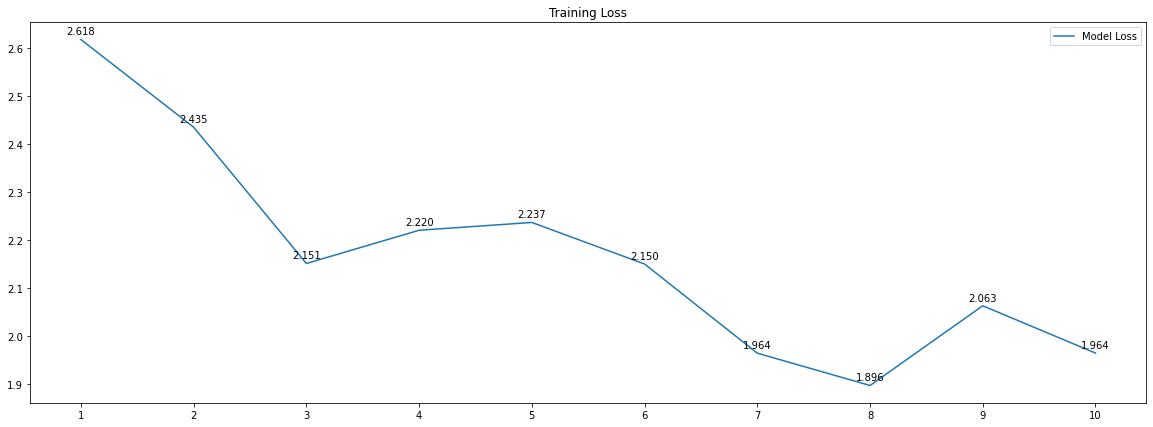

In [ ]:
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(20, 7))
plt.plot(epochs, losses, label='Model Loss', )
plt.legend()
plt.title('Training Loss')
plt.xticks(epochs)
for x, y in zip(epochs, losses):
    label = "{:.3f}".format(y)
    plt.annotate(label,                               # this is the text
                (x, y),                              # this is the point to label
                textcoords="offset points",          # how to position the text
                xytext=(0, 5),                       # distance from text to points (x,y)
                ha='center')                         # horizontal alignment can be left, right or center

### Testing

In [ ]:
def predict(lang1, lang2, num, tokenizer1, tokenizer2):
    for _ in range(num):
        index = np.random.choice(len(lang1))
        test_source_text = lang1[index]
        print(test_source_text)

        test_source_seq = tokenizer1.texts_to_sequences([test_source_text])
        test_source_pad_seq = pad(test_source_seq, mx_en, 'pre', 'pre')

        en_initial_states = encoder.init_states(1)
        en_outputs = encoder(tf.constant(test_source_pad_seq), en_initial_states)

        de_input = tf.constant([[tokenizer2.word_index['<start>']]])
        de_state_h, de_state_c = en_outputs[1:]
        out_words = []

        while True:
            de_output, de_state_h, de_state_c = decoder(de_input, (de_state_h, de_state_c))
            de_input = tf.argmax(de_output, -1)
            out_words.append(tokenizer2.index_word[de_input.numpy()[0][0]])
            # out_words.append(tokenizer2.decode[de_input.numpy()[0][0]])

            if out_words[-1] == '<end>' or len(out_words) >= FR_MX_LEN:
                break

        print(' '.join(out_words))

        print(lang2[index], end='\n\n')

In [ ]:
predict(lang1=en, lang2=fr, num=5, tokenizer1=en_tokenizer, tokenizer2=fr_tokenizer)

<start> even though it s small , it s still my apartment . <end>
que je suis de l ecole . <end>
<start> meme s il est petit , c est tout de meme mon appartement . <end>

<start> your question is hard to answer . <end>
ce qui est un peu de temps . <end>
<start> il est difficile de repondre a ta question . <end>

<start> tom has very short hair . <end>
tom a l ecole a la . <end>
<start> tom a les cheveux tres courts . <end>

<start> it could just be your imagination . <end>
vous il n ai pas de ce que je suis pas ? <end>
<start> ce pourrait simplement etre votre imagination . <end>

<start> stop screaming like a girl . <end>
il a dit que tu ne peux pas pas de l argent . <end>
<start> cesse de hurler comme une fille ! <end>



## Seq2Seq with Attention Model

![Attention Model](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

---

![Attention Equations](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)

![Scores](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)

---

+ **Luong Attention Score**
<br/>

![Luong Attention Score](https://machinetalk.org/wp-content/uploads/2019/03/score_eq-455x111.png)

---

Here’s the key differences between the two:

+ Bahdanau attention mechanism proposed only the concat score function.
+ Luong-style attention uses the current decoder output to compute the alignment vector, whereas Bahdanau’s uses the output of the previous time step.

### Encoder

In [ ]:
class AttentionEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size):
        super(AttentionEncoder, self).__init__(name='AttentionEncoder')
        self.rnn_size = rnn_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.compat.v1.keras.layers.CuDNNLSTM(units=rnn_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.rnn_size]), tf.zeros([batch_size, self.rnn_size]))

In [ ]:
encoder = AttentionEncoder(vocab_size=EN_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, rnn_size=LSTM_SIZE)

### Attention

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__(name='LuongAttention')
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError('Unknown attention score function! Must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(units=rnn_size)

        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(units=rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(units=1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True)

        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)

        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(decoder_output, [1, encoder_output.shape[1], 1])

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1])

        # alignment a_t = softmax(score) => Attention weights
        alignment = tf.nn.softmax(score, axis=2)

        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output)

        return context, alignment

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, rnn_size):
        super(BahdanauAttention, self).__init__(name='BahdanauAttention')
        self.W1 = tf.keras.layers.Dense(units=rnn_size)
        self.W2 = tf.keras.layers.Dense(units=rnn_size)
        self.V = tf.keras.layers.Dense(units=1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Decoder

In [ ]:
class AttentionDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size, attention_type, attention_func):
        super(AttentionDecoder, self).__init__(name='AttentionDecoder')

        if attention_type:
            self.attention = LuongAttention(rnn_size, attention_func)
        else:
            self.attention = BahdanauAttention(rnn_size)
        self.rnn_size = rnn_size

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.lstm = tf.compat.v1.keras.layers.CuDNNLSTM(units=rnn_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(units=rnn_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(units=vocab_size)

    def call(self, sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, rnn_size)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, rnn_size),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * rnn_size)
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, rnn_size)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [ ]:
decoder = AttentionDecoder(vocab_size=FR_VOCAB_SIZE, embedding_size=EMBEDDING_SIZE, rnn_size=LSTM_SIZE, attention_type=True, attention_func='concat')

### Defining Loss Function

In [ ]:
# ignoring padded zeroes
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(targets, 0)), dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

### Defining Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam()

### Training

In [ ]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, enc_obj, dec_obj, enc_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = enc_obj(source_seq, enc_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    variables = enc_obj.trainable_variables + dec_obj.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [ ]:
attention_losses = []
for e in range(NUM_EPOCHS):
    start = time.time()
    enc_initial_states = encoder.init_states(BATCH_SIZE)

    for batch, (source_seq, target_seq_in, target_seq_out) in tqdm(enumerate(dataset.take(-1)), desc='Epoch - '+str(e+1), total=TRAIN_BATCH_SIZE):
        loss = train_step(source_seq, target_seq_in, target_seq_out, encoder, decoder, enc_initial_states)

    attention_losses.append(loss)
    end = time.time()

    print('Epoch: {} \t Loss: {:.9f} \t Time: {:.9f}'.format(e + 1, loss.numpy(), end-start))


Epoch: 1 	 Loss: 1.745354652 	 Time: 140.926102161



Epoch: 2 	 Loss: 1.562590361 	 Time: 117.865712881



Epoch: 3 	 Loss: 1.568447709 	 Time: 117.163588524



Epoch: 4 	 Loss: 1.454453468 	 Time: 117.295356035



Epoch: 5 	 Loss: 1.245087504 	 Time: 117.981014252



Epoch: 6 	 Loss: 1.251648426 	 Time: 117.540340185



Epoch: 7 	 Loss: 1.278036475 	 Time: 117.288819790



Epoch: 8 	 Loss: 1.274777055 	 Time: 117.984716415



Epoch: 9 	 Loss: 1.187485218 	 Time: 118.356685877



Epoch: 10 	 Loss: 1.268300414 	 Time: 118.561176300


### Analysis

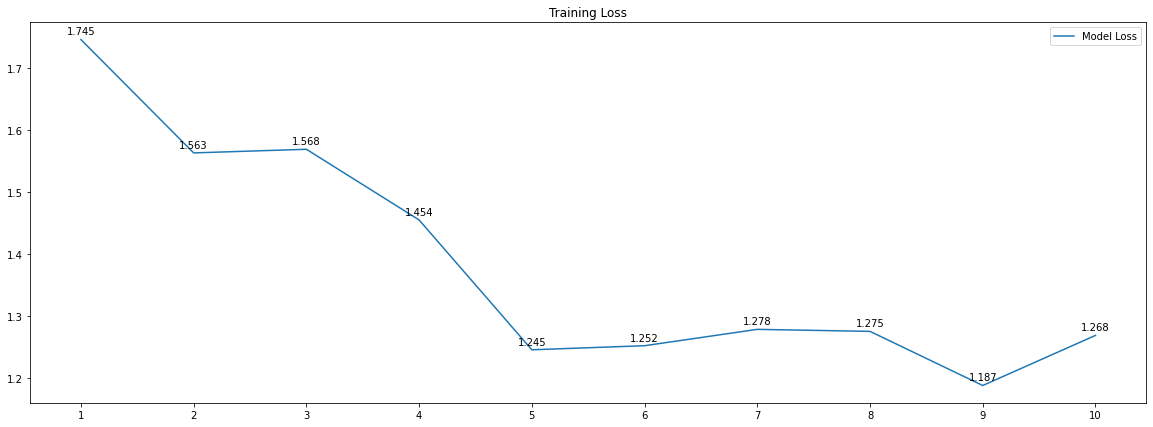

In [ ]:
epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(20, 7))
plt.plot(epochs, attention_losses, label='Model Loss', )
plt.legend()
plt.title('Training Loss')
plt.xticks(epochs)
for x, y in zip(epochs, attention_losses):
    label = "{:.3f}".format(y)
    plt.annotate(label,                               # this is the text
                (x, y),                              # this is the point to label
                textcoords="offset points",          # how to position the text
                xytext=(0, 5),                       # distance from text to points (x,y)
                ha='center')                         # horizontal alignment can be left, right or center

### Testing

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [ ]:
def attentionPredict(lang1, lang2, num, tokenizer1, tokenizer2):
    for _ in range(num):
        index = np.random.choice(len(lang1))
        test_source_text = lang1[index]
        print(test_source_text)

        test_source_seq = tokenizer1.texts_to_sequences([test_source_text])
        # test_source_pad_seq = pad(test_source_seq, mx_en, 'pre', 'pre')

        en_initial_states = encoder.init_states(1)
        # en_outputs = encoder(tf.constant(test_source_pad_seq), en_initial_states)
        en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

        de_input = tf.constant([[tokenizer2.word_index['<start>']]])
        de_state_h, de_state_c = en_outputs[1:]
        out_words, alignments = [], []

        while True:
            de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
            de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
            out_words.append(tokenizer2.index_word[de_input.numpy()[0][0]])
            alignments.append(tf.reshape(alignment, (-1, )).numpy())

            if out_words[-1] == '<end>' or len(out_words) >= 20:
                break

        print(' '.join(out_words))

        print(lang2[index], end='\n\n')
        
        plot_attention(attention=alignments, sentence=test_source_text.split(), predicted_sentence=lang2[index].split())

<start> i gather you were unsuccessful . <end>
mere que je pas . <end>
<start> je conclus que tu n as pas reussi . <end>

<start> i want for you and me to be happy . <end>
arrive que je veux ce que je me demande et . <end>
<start> je veux que vous et moi soyons heureuses . <end>

<start> i ve got to do my chores . <end>
mere que je suis de faire . <end>
<start> je dois faire mes corvees . <end>

<start> how do i change my cell phone s ringtone ? <end>
que comment se de notre de mon numero de telephone de son ? <end>
<start> comment puis je changer la sonnerie de mon telephone portable ? <end>

<start> we worry about your future . <end>
de nous ? nous ? <end>
<start> nous nous faisons du souci pour votre avenir . <end>



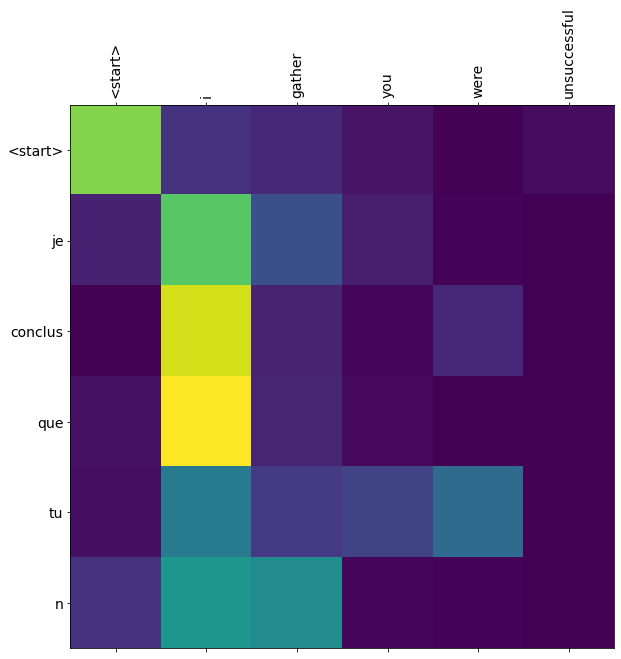

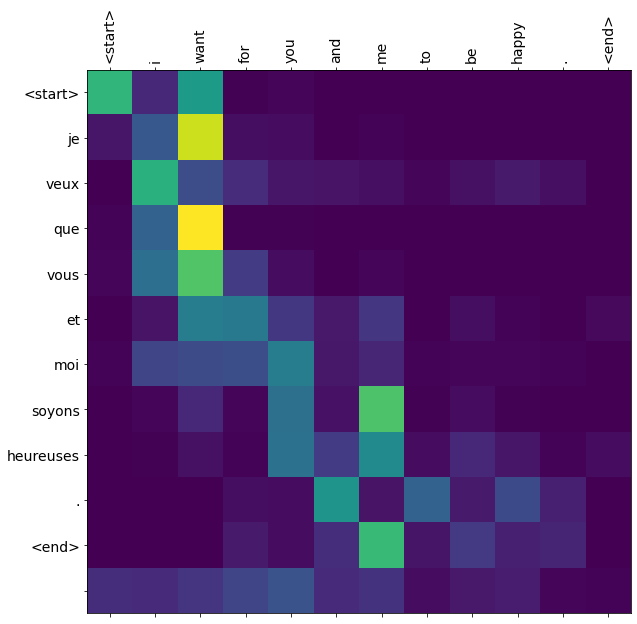

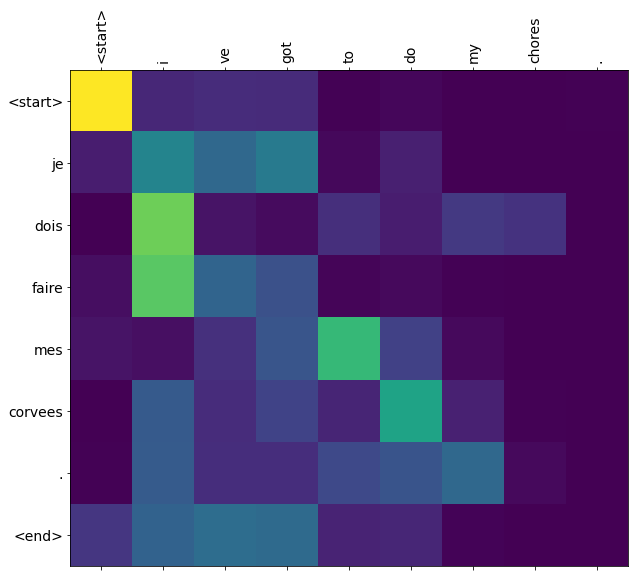

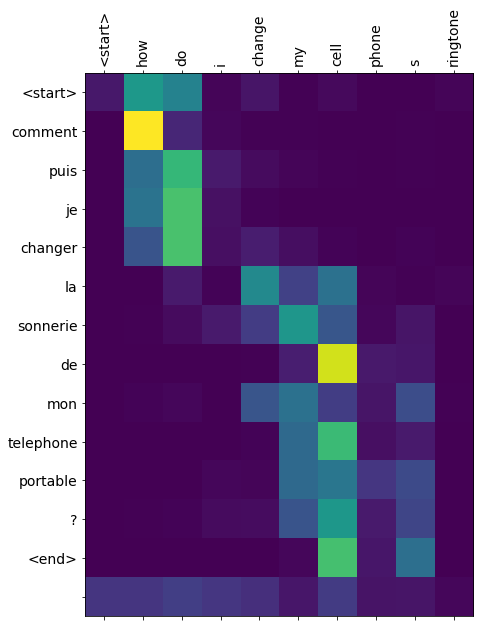

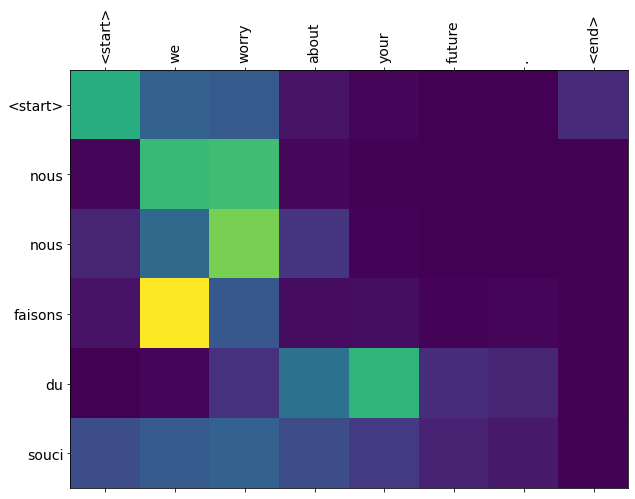

In [ ]:
attentionPredict(lang1=en, lang2=fr, num=5, tokenizer1=en_tokenizer, tokenizer2=fr_tokenizer)

## Transformer

### Positional Encoding

![Positional Encoding](https://machinetalk.org/wp-content/uploads/2019/05/positional_encoding.png)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__(name='PositionalEncoding')

    # pos: (seq_len, 1), i: (1, d_model)
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000., (2*(i//2)/np.float32(d_model)))
        return pos * angles     # (seq_len, d_model)

    def call(self, inputs):
        seq_len = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]

        angles = self.get_angles(pos=np.arange(seq_len)[:, np.newaxis], i=np.arange(d_model)[np.newaxis, :], d_model=d_model)
        
        # apply sin to even indices in the array; 2i
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        
        # apply cos to odd indices in the array; 2i+1
        angles[:, 1::2] = np.cos(angles[:, 1::2])

        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(x=pos_encoding, dtype=tf.float32)

(1, 50, 512)


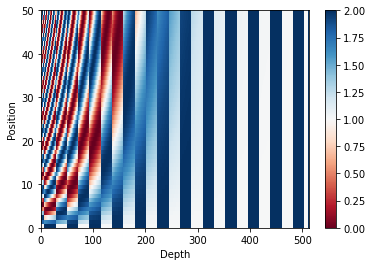

In [ ]:
pos_encoding = PositionalEncoding()
pos_encoding = pos_encoding(tf.ones(shape=(50, 512)))
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar();

### Attention

![Attention](https://miro.medium.com/max/1050/0*2TK7PpioimJzc2nK)

---

![Attention Math](https://miro.medium.com/max/1050/0*h9UyFTmjKn1qzfOt)
*where **Q**:Queries, **K**:Keys, **V**:Values*

+ As the softmax normalization is done on K, its values decide the amount of importance given to Q.
+ The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

---

![Attention Process](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

---

![Insight into Multi-Head Attention](https://machinetalk.org/wp-content/uploads/2019/04/one_head-1.png)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__(name='MultiHeadAttention')
        self.nb_proj = nb_proj


    # queries: (..., seq_len_q, d_proj), keys: (..., seq_len_k, d_proj), values: (..., seq_len_v, d_proj_v),
    # mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.
    def scaled_dot_product_attention(self, queries, keys, values, mask):
        # product: (..., seq_len_q, seq_len_k)
        product = tf.matmul(a=queries, b=keys, transpose_a=False, transpose_b=True, adjoint_a=False, adjoint_b=False, a_is_sparse=False, b_is_sparse=False)

        # scale matmul_qk
        keys_dim = tf.cast(tf.shape(input=keys)[-1], tf.float32)
        scaled_product = product / tf.math.sqrt(x=keys_dim)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_product += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
        attention_weights = tf.nn.softmax(logits=scaled_product, axis=-1)           # (..., seq_len_q, seq_len_k)
        output = tf.matmul(a=attention_weights, b=values)                           # (..., seq_len_q, d_proj_v)
        return output, attention_weights


    def build(self, input_shape):
        self.d_model = input_shape[-1]

        assert (self.d_model % self.nb_proj) == 0
        self.d_proj = self.d_model // self.nb_proj

        self.wq = tf.keras.layers.Dense(units=self.d_model, activation=None)
        self.wk = tf.keras.layers.Dense(units=self.d_model, activation=None)
        self.wv = tf.keras.layers.Dense(units=self.d_model, activation=None)

        self.final_lin = tf.keras.layers.Dense(units=self.d_model, activation=None)


    # inputs: (batch_size, seq_len, d_model)
    def split_proj(self, inputs, batch_size):
        shape = (batch_size, -1, self.nb_proj, self.d_proj)
        splitted_inputs = tf.reshape(tensor=inputs, shape=shape)                       # (batch_size, seq_len, nb_proj, d_proj)
        return tf.transpose(a=splitted_inputs, perm=[0, 2, 1, 3], conjugate=False)     # (batch_size, nb_proj, seq_len, d_proj)


    def call(self, queries, keys, values, mask):
        batch_size = tf.shape(input=queries)[0]

        queries = self.wq(queries)                                                      # (batch_size, seq_len_q, d_model)
        keys = self.wk(keys)                                                            # (batch_size, seq_len_k, d_model)
        values = self.wv(values)                                                        # (batch_size, seq_len_v, d_model)

        queries = self.split_proj(inputs=queries, batch_size=batch_size)                # (batch_size, nb_proj, seq_len_q, d_proj)
        keys = self.split_proj(inputs=keys, batch_size=batch_size)                      # (batch_size, nb_proj, seq_len_k, d_proj)
        values = self.split_proj(inputs=values, batch_size=batch_size)                  # (batch_size, nb_proj, seq_len_v, d_proj)

        # attention: (batch_size, nb_proj, seq_len_q, d_proj)
        # attention_weights: (batch_size, nb_proj, seq_len_q, seq_len_k)
        attention, attention_weights = self.scaled_dot_product_attention(queries=queries, keys=keys, values=values, mask=mask)
        attention = tf.transpose(a=attention, perm=[0, 2, 1, 3], conjugate=False)                   # (batch_size, seq_len_q, nb_proj, d_proj)
        concat_attention = tf.reshape(tensor=attention, shape=(batch_size, -1, self.d_model))       # (batch_size, seq_len_q, d_model)

        outputs = self.final_lin(concat_attention)                                      # (batch_size, seq_len_q, d_model)
        return outputs, attention_weights

### Encoder

![Transformer Encoder](https://machinetalk.org/wp-content/uploads/2019/04/encoder.png)

---

![Data Shapes inside the Encoder](https://machinetalk.org/wp-content/uploads/2019/04/encoder_shape.png)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, ffn_units, nb_proj, dropout_rate):
        super(EncoderLayer, self).__init__(name='EncoderLayer')
        self.ffn_units = ffn_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate


    def build(self, input_shape):
        self.d_model = input_shape[-1]

        self.multi_head_attention = MultiHeadAttention(nb_proj=self.nb_proj)
        self.dropout_1 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6, center=True, scale=True)
        self.dense_1 = tf.keras.layers.Dense(units=self.ffn_units, activation='relu')

        self.dense_2 = tf.keras.layers.Dense(units=self.d_model, activation=None)
        self.dropout_2 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6, center=True, scale=True)


    def call(self, inputs, mask, training_flag):
        attention, _ = self.multi_head_attention(queries=inputs, keys=inputs, values=inputs, mask=mask)    # (batch_size, seq_len, d_model)
        attention = self.dropout_1(attention, training=training_flag)
        attention = self.norm_1(attention + inputs)                                                        # (batch_size, seq_len, d_model)

        outputs = self.dense_1(attention)                                                                  # (batch_size, seq_len, ffn_units)
        outputs = self.dense_2(outputs)                                                                    # (batch_size, seq_len, d_model)
        outputs = self.dropout_2(outputs, training=training_flag)
        outputs = self.norm_2(outputs + attention)                                                         # (batch_size, seq_len, d_model)

        return outputs

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, nb_layers, ffn_units, nb_proj, dropout_rate, vocab_size, d_model):
        super(Encoder, self).__init__(name='Encoder')
        self.nb_layers = nb_layers
        self.d_model = d_model

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=None)
        self.pos_encoding = PositionalEncoding()
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(ffn_units=ffn_units, nb_proj=nb_proj, dropout_rate=dropout_rate) for _ in range(nb_layers)]


    def call(self, inputs, mask, training_flag):
        outputs = self.embedding(inputs)                                            # (batch_size, seq_len, d_model)
        outputs *= tf.math.sqrt(x=tf.cast(x=self.d_model, dtype=tf.float32))
        outputs = self.pos_encoding(inputs=outputs)
        outputs = self.dropout(outputs, training=training_flag)

        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](inputs=outputs, mask=mask, training_flag=training_flag)

        return outputs                                                              # (batch_size, seq_len, d_model)

### Decoder

![Transformer Decoder](https://machinetalk.org/wp-content/uploads/2019/04/decoder.png)

---

![Data Shapes inside the Decoder](https://machinetalk.org/wp-content/uploads/2019/04/decoder_shape-2.png)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, ffn_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__(name='DecoderLayer')
        self.ffn_units = ffn_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate


    def build(self, input_shape):
        self.d_model = input_shape[-1]

        self.multi_head_attention_1 = MultiHeadAttention(nb_proj=self.nb_proj)
        self.dropout_1 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6, center=True, scale=True)

        self.multi_head_attention_2 = MultiHeadAttention(nb_proj=self.nb_proj)
        self.dropout_2 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6, center=True, scale=True)
        self.dense_2 = tf.keras.layers.Dense(units=self.ffn_units, activation='relu')

        self.dense_3 = tf.keras.layers.Dense(units=self.d_model, activation=None)
        self.dropout_3 = tf.keras.layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-6, center=True, scale=True)


    # enc_outputs: (batch_size, seq_len, d_model)
    def call(self, inputs, enc_outputs, mask_1, mask_2, training_flag):
        # attention_1: (batch_size, seq_len, d_model)
        attention_1, attention_weights_block1 = self.multi_head_attention_1(queries=inputs, keys=inputs, values=inputs, mask=mask_1)
        attention_1 = self.dropout_1(attention_1, training=training_flag)
        attention_1 = self.norm_1(attention_1 + inputs)                                 # (batch_size, seq_len, d_model)

        # attention_2: (batch_size, seq_len, d_model)
        attention_2, attention_weights_block2 = self.multi_head_attention_2(queries=attention, keys=enc_outputs, values=enc_outputs, mask=mask_2)
        attention_2 = self.dropout_2(attention_2, training=training_flag)
        attention_2 = self.norm_2(attention_2 + attention_1)                            # (batch_size, seq_len, d_model)

        outputs = self.dense_2(attention_2)                                             # (batch_size, seq_len, ffn_units)
        outputs = self.dense_3(outputs)                                                 # (batch_size, seq_len, d_model)
        outputs = self.dropout_3(outputs, training=training_flag)
        outputs = self.norm_3(outputs + attention_2)                                    # (batch_size, seq_len, d_model)

        return outputs, attention_weights_block1, attention_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, nb_layers, ffn_units, nb_proj, dropout_rate, vocab_size, d_model):
        super(Decoder, self).__init__(name='Decoder')
        self.nb_layers = nb_layers
        self.d_model = d_model

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=None)
        self.pos_encoding = PositionalEncoding()
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.dec_layers = [DecoderLayer(ffn_units=ffn_units, nb_proj=nb_proj, dropout_rate=dropout_rate) for _ in range(nb_layers)]


    def call(self, inputs, enc_outputs, mask_1, mask_2, training_flag):
        attention_weights = {}
        outputs = self.embedding(inputs)                                            # (batch_size, seq_len, d_model)
        outputs *= tf.math.sqrt(x=tf.cast(x=self.d_model, dtype=tf.float32))
        outputs = self.pos_encoding(inputs=outputs)
        outputs = self.dropout(outputs, training=training_flag)

        for i in range(self.nb_layers):
            outputs, b1, b2 = self.dec_layers[i](inputs=outputs, enc_outputs=enc_outputs, mask_1=mask_1, mask_2=mask_2, training_flag=training_flag)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = b1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = b2
            
        return outputs                                                              # (batch_size, seq_len, d_model)

### Transformer Model

![Transformer Model](https://machinetalk.org/wp-content/uploads/2019/04/transformer-1.png)

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size_enc, vocab_size_dec, d_model, nb_layers, ffn_units, nb_proj, dropout_rate):
        super(Transformer, self).__init__(name='Transformer')

        self.encoder = Encoder(
            nb_layers=nb_layers,
            ffn_units=ffn_units,
            nb_proj=nb_proj,
            dropout_rate=dropout_rate,
            vocab_size=vocab_size_enc,
            d_model=d_model
        )
        self.decoder = Decoder(
            nb_layers=nb_layers,
            ffn_units=ffn_units,
            nb_proj=nb_proj,
            dropout_rate=dropout_rate, 
            vocab_size=vocab_size_dec,
            d_model=d_model
        )
        self.final_linear = tf.keras.layers.Dense(units=vocab_size_dec, activation=None)


    # seq: (batch_size, seq_len)
    def create_padding_mask(self, seq):
        mask = tf.cast(x=tf.math.equal(x=seq, y=0), dtype=tf.float32)
        
        # add extra dimensions to add the padding to the attention logits.
        return mask[:, tf.newaxis, tf.newaxis, :]           # (batch_size, 1, 1, seq_len)


    # seq: (batch_size, seq_len)
    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(input=seq)[-1]

        # creating upper triangular matrix
        look_ahead_mask = 1 - tf.linalg.band_part(input=tf.ones(shape=(seq_len, seq_len)), num_lower=-1, num_upper=0)
        return look_ahead_mask                              # (seq_len, seq_len)


    def call(self, enc_inputs, dec_inputs, training_flag):
        enc_mask = self.create_padding_mask(seq=enc_inputs)
        dec_mask_1 = tf.maximum(x=self.create_padding_mask(seq=dec_inputs), y=self.create_look_ahead_mask(seq=dec_inputs))
        dec_mask_2 = self.create_padding_mask(seq=enc_inputs)

        enc_outputs = self.encoder(inputs=enc_inputs, mask=enc_mask, training_flag=training_flag)       # (batch_size, seq_len, d_model)
        # dec_outputs: (batch_size, seq_len, d_model)
        dec_outputs, attention_weights = self.decoder(inputs=dec_inputs, enc_outputs=enc_outputs, mask_1=dec_mask_1, mask_2=dec_mask_2, 
                                                      training_flag=training_flag)

        outputs = self.final_linear(dec_outputs)                                    # (batch_size, seq_len, vocab_size_dec)
        return outputs, attention_weights

### Setting-up Parameters

In [ ]:
D_MODEL = 128           # 512
NB_LAYERS = 4           # 6
FFN_UNITS = 512         # 2048
NB_PROJ = 8             # 8
DROPOUT_RATE = 0.1      # 0.1

### Defining Loss Function

In [ ]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
# ignoring padded zeroes
def loss_func(targets, logits):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(targets, 0)), dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return tf.reduce_mean(loss)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### Defining Optimizer

![LearningRate](https://i0.wp.com/rubikscode.net/wp-content/uploads/2019/08/image-9.png?w=791&ssl=1)
+ Adam optimizer with β1 = 0.9, β2 = 0.98 and epsilon = 10^−9

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(x=d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps


    def __call__(self, step):
        arg1 = tf.math.rsqrt(x=step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(x=self.d_model) * tf.math.minimum(x=arg1, y=arg2)

In [ ]:
learning_rate = CustomSchedule(d_model=D_MODEL, warmup_steps=4000)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09)

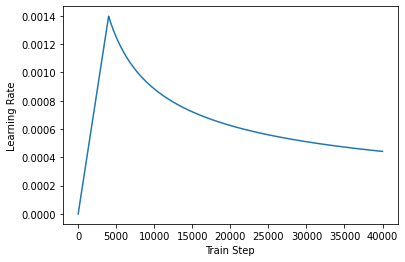

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model=D_MODEL, warmup_steps=4000)

plt.plot(temp_learning_rate_schedule(tf.range(start=40000, limit=None, delta=1, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step");

### Training

In [ ]:
transformer = Transformer(
    vocab_size_enc=EN_VOCAB_SIZE,
    vocab_size_dec=FR_VOCAB_SIZE,
    d_model=D_MODEL,
    nb_layers=NB_LAYERS,
    ffn_units=FFN_UNITS,
    nb_proj=NB_PROJ,
    dropout_rate=DROPOUT_RATE
)

In [ ]:
checkpoint_path = './drive/My Drive/Colab Notebooks/transformer/ckpt/'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, directory=checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(save_path=ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

In [ ]:
for epoch in range(NUM_EPOCHS):
    